En este cuaderno voy a hacer una análisis del dataset** mbti_1.csv** el cual contiene una colección de más de 8000 observaciones de tweetes de usarios etiquetasdos con el rasgp de personalidad de Myers-Briggs

Según Cattell, en cada persona existe un continuo en los rasgos de personalidad. En otras palabras, cada persona contiene todos estos 16 rasgos en un cierto grado, pero puede ser más alto en algunos rasgos y más bajo en otros. Por ejemplo, aunque todas las personas tienen cierto nivel de abstracción, algunas pueden ser muy imaginativas, mientras que otros son muy prácticas.

El test elaborado por Cattel llamado 16PF mide 16 factores básicos que están identificados de la siguiente manera: A, B, C, E, F, G, H, I, L, M, N, O, Q1, Q2, Q3, & Q4; más cinco factores de segundo orden. Estos factores están ordenados de acuerdo a su repercusión sobre la conducta en general, siendo el Factor A el de mayor influencia.


# **Lo que voy a intentar es entrenar diferentes algoritmos sobre los tweets denlas observaciones para poder predecir el tipo de personalidad de una serie de relatos búscados al azar.**

In [0]:
!pip install gensim
!pip install pyLDAvis
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install stop_words
!pip install gensim
!pip install pyLDAvis
!pip install stop_words
!python -m textblob.download_corpora
!pip install textblob

     |████████████████████████████████| 1.6MB 3.5MB/s 
     |████████████████████████████████| 552kB 43.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=4a1c1898180a939594387be9b94750e1420e7d2f07aa52ab5623294adf35692c
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=548ba386f34ed144c6e0bc7b8c24080a232d7ae63520b37a825e3cc47b7ca1cb
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=3d1a2fef1a3ac39ecdf48578ad69327d318d794ee8b44ce8531ca38f1622b82a
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd0729

# **Librerias necesarias**

In [0]:
import numpy as np 
import pandas as pd
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
from stop_words import get_stop_words
from string import punctuation
import spacy
from random import sample
import re
from html.parser import HTMLParser
import keras
from keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import nltk
nltk.download("wordnet")
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from pylab import rcParams
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from itertools import compress
from sklearn.model_selection import learning_curve
import en_core_web_sm
nlp = en_core_web_sm.load()
from collections import Counter

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Importamos el repo de gitlab donde estan los datos.

In [0]:
!git clone https://gitlab.com/davidllorenteraposo/proyectofinalkcdll.git

Cloning into 'proyectofinalkcdll'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
Checking out files: 100% (5/5), done.


**ANÁLISIS DEL DATASET**

En este notebook voy a utilizar el dataset mbti_1.csv el cuál contiene 8.675 tweets etiquetados con los 16 tipos de personalidad de Myers-Briggs descritos anteriormente.

Cargamos el dataset

In [0]:
myersBriggs16P_df = pd.read_csv('proyectofinalkcdll/data/myersBriggs16P.csv',encoding="ISO-8859-1")
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

Vemos el shape de nuestros datos

In [0]:
myersBriggs16P_df.shape

(8675, 2)

Vemos los tipos de personalidad descritos anteriormente

In [0]:
np.unique(myersBriggs16P_df['type'])

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

Vemos un poco de ingo de nuestras variables

In [0]:
myersBriggs16P_df.info

<bound method DataFrame.info of       type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
5     INTJ  '18/37 @.@|||Science  is not perfect. No scien...
6     INFJ  'No, I can't draw on my own nails (haha). Thos...
7     INTJ  'I tend to build up a collection of things on ...
8     INFJ  I'm not sure, that's a good question. The dist...
9     INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...
10    INFJ  'One time my parents were fighting over my dad...
11    ENFJ  'https://www.youtube.com/watch?v=PLAaiKvHvZs||...
12    INFJ  'Joe santagato - ENTP|||ENFJ or  ENTP?   I'm n...
13    INTJ  'Fair enough, if that's how you want to look a...
14    INTP  'Basically this...  https:

In [0]:
myersBriggs16P_df.describe()

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'So uh, I came across this gem after stumbling...
freq    1832                                                  1

Vemos que se trata de un dataset con 2 columnas y 8675 observaciones

Tenemos 16 tipos de personalidad en la variable categorica 'type'.

No parece que haya valores faltantes pero vamos a asegurarnos

In [0]:
# Función para calcular los missings
def missing_values(df):
        # Total
        mis_val = df.isnull().sum()
        
        # Porcentaje
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Hago la tabla
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Columnas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Ordeno
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
       
        print ("El dataframe seleccionado tiene " + str(df.shape[1]) + " columnas.\n"      
            "Existen " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas que tienen missings.")
        
        # Return 
        return mis_val_table_ren_columns
missing_values(myersBriggs16P_df)

El dataframe seleccionado tiene 2 columnas.
Existen 0 columnas que tienen missings.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Vemos que no hay columnas con missings.

Vamos a plotear la variable '**type**' de nuestro dataset la cual va a ser nuestro target cuando hagamos el analisis.

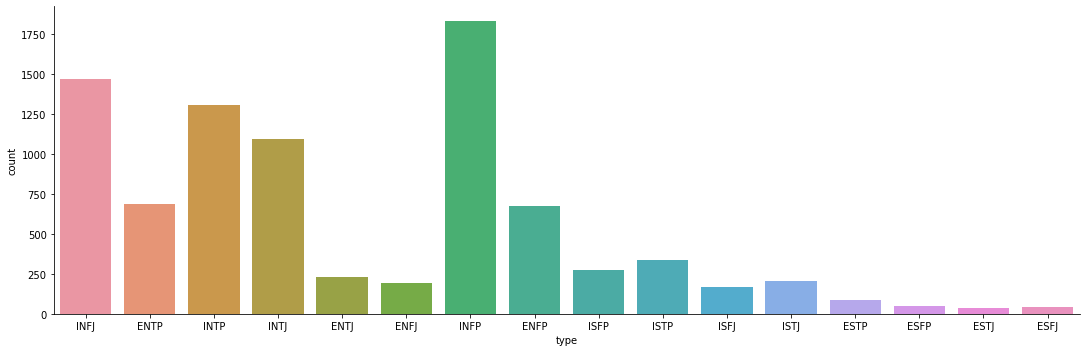

In [0]:
sb.factorplot('type',data=myersBriggs16P_df,kind="count", aspect=3)

Tweets por personalidad

In [0]:
myersBriggs16P_df.groupby('type').agg(['count']).stack()

posts
type             
ENFJ count    190
ENFP count    675
ENTJ count    231
ENTP count    685
ESFJ count     42
ESFP count     48
ESTJ count     39
ESTP count     89
INFJ count   1470
INFP count   1832
INTJ count   1091
INTP count   1304
ISFJ count    166
ISFP count    271
ISTJ count    205
ISTP count    337

De este resultado podemos sacar en claro que la distribución no esta balanceada y que las personalidades antes descritas como mas abundantes actuaran en contra de nuestras poredicciones.

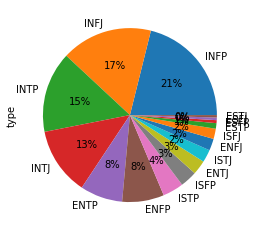

In [0]:
myersBriggs16P_df.type.value_counts().plot(kind='pie', autopct='%1.0f%%') 

Por lo que vemos los tipos de personalidad mas abundantes son INFP , INFJ , INTP , INTJ , es decir a simple vista parece que la introversión y la negatividad son factores importantes dentro de las personalidades de la muestra. 

Vemos que los datos no estan muy bien balanceados lo que puede ocasionar problemas en los resultyados de los algoritmos, ya sea porque dará mas peso a las observaciones mas numerosas.

Vamos a seguir con lo que tenemos.

Vamos a mostrar 100 observaciones al azar.

In [0]:
for i in range(0,len(myersBriggs16P_df),100):
  print(myersBriggs16P_df['type'][i], "\t", myersBriggs16P_df['posts'][i])

INFJ 	 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.j

Nuestros datos se tratan de 8675 observaciones con 2 variables:

type --> CORRESPONDE AL TIPO DE PERSONALIDAD (TARGET)

posts --> la lista de tweets de cada usuario

In [0]:
myersBriggs16P_df['posts'][0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

Podemos ver que la variable posts se trata de una lista de tweets separados por || de cada una de las personalidades.

Como queremos realizar un análisis de estos lo que vamos a hacer es crearnos una columna nueva donde vamos a separar los tweets por || y otra columna donde contaremos el número de tweets que tiene cada observación.

In [0]:
#nos creamos una lista de tweets por cada observacion
myersBriggs16P_df['tweets_sep'] = myersBriggs16P_df['posts'].apply(lambda x: x.strip().split("|||"))
#añadimos columna que nos indica el número de tweets de cada observación
myersBriggs16P_df['num_tweets'] = myersBriggs16P_df['tweets_sep'].apply(lambda x: len(x))

In [0]:
num_post_df = myersBriggs16P_df.groupby('type')['num_tweets'].apply(list).reset_index()

Text(0, 0.5, 'Número de tweets')

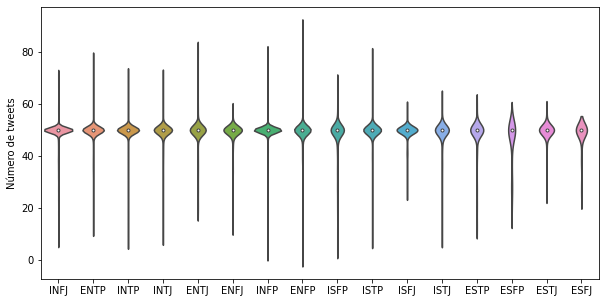

In [0]:
rcParams['figure.figsize'] = 10,5
sb.violinplot(x='type',y='num_tweets',data=myersBriggs16P_df)
plt.xlabel('')
plt.ylabel('Número de tweets')

En la gráfica de arriba podemos ver el número de tweets de cada personalidad, con media de 50 tweets.


In [0]:
myersBriggs16P_df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                          tweets_sep  num_tweets  
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...          50  
1  ['I'm finding the lack of me in these posts ve...          50  
2  ['Good one  _____   https://www.youtube.com/wa...          50  
3  ['Dear INTP,   I enjoyed our conversation the ...          50  
4  ['You're fired., That's another silly misconce...          50

Como lo que queremos es que haya un solo tweet por fila y que este se corresponda al mismo paciente de la observación, nos vamos a crar una columna que identifique a cada realziador de los tweets.

In [0]:
myersBriggs16P_df['patientId'] = myersBriggs16P_df.index

In [0]:
myersBriggs16P_df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                          tweets_sep  num_tweets  patientId  
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...          50          0  
1  ['I'm finding the lack of me in these posts ve...          50          1  
2  ['Good one  _____   https://www.youtube.com/wa...          50          2  
3  ['Dear INTP,   I enjoyed our conversation the ...          50          3  
4  ['You're fired., That's another silly misconce...          50          4

Ahora que tenemos creada la columna patientId y la lista de cada tweet de los pacientes, vamos a crearnos una nueva observacion por cada tweet, recorreremos por ejemplo los 50 tweets del paciente0 y crearemos una observación por cada uno de ellos.

In [0]:
myersBriggs16PTotal_df = pd.DataFrame(myersBriggs16P_df['tweets_sep'].tolist(), index=myersBriggs16P_df['patientId']).stack().reset_index(level=1, drop=True).reset_index(name='tweet')

Vemos como nos a quedado el dataset y el tamaño del mismo

In [0]:
myersBriggs16PTotal_df.head(1)

patientId                                        tweet
0          0  'http://www.youtube.com/watch?v=qsXHcwe3krw

In [0]:
myersBriggs16PTotal_df.shape

(422845, 2)

Vemos que han incrementado muchísimo el número de observaciones por desglosar los tweets de cada observación o paciente.

Ahora lo que debemos hacer es unir con un join los 2 datasets por el identificador del usuario para tener solo un dataset con los tweets de todos los usuarios expandidos.

También vamos a eliminar las columnas que ya no nos hacen falta.

In [0]:
myersBriggs16PTotal_df=myersBriggs16PTotal_df.join(myersBriggs16P_df.set_index('patientId'), on='patientId', how = 'left')
myersBriggs16PTotal_df=myersBriggs16PTotal_df.drop(columns=['posts','tweets_sep','num_tweets'])

Vamos a ver como nos ha quedado nuestro dataset.

In [0]:
myersBriggs16PTotal_df.head(1)

patientId                                        tweet  type
0          0  'http://www.youtube.com/watch?v=qsXHcwe3krw  INFJ

Ya tenemos nuestro dataset preparado para poder entrenar los algoritmos.

Antés vamos a acabar con el análisis y voy a ver el número de palabraspor tweet de las diferentes personalidades.

In [0]:
myersBriggs16PTotal_df['numberOfWords']=myersBriggs16PTotal_df['tweet'].apply(lambda x: len(x.split()))
myersBriggs16PTotal_df.head()

patientId                                              tweet  type  \
0          0        'http://www.youtube.com/watch?v=qsXHcwe3krw  INFJ   
1          0  http://41.media.tumblr.com/tumblr_lfouy03PMA1q...  INFJ   
2          0  enfp and intj moments  https://www.youtube.com...  INFJ   
3          0  What has been the most life-changing experienc...  INFJ   
4          0  http://www.youtube.com/watch?v=vXZeYwwRDw8   h...  INFJ   

   numberOfWords  
0              1  
1              1  
2             12  
3             10  
4              8

Vemos con las url's las toma como solo una palabra.

Podemos mostrarlas en un gráfico.

In [0]:
plt.figure(figsize=(15,10))
sb.swarmplot("type", "numberOfWords", data=myersBriggs16PTotal_df)

Viendo los tweets vemos que debemos hacer un buen preprocesamiento de los datos para que le lleguen a los algoritmos los datos lo mas limpios posibles.

Ántes de nada podemos ver el tamaño del corpus del que disponemos.

In [0]:
myersBriggs16PTotal_df=myersBriggs16PTotal_df.drop(columns=['numberOfWords'])

In [0]:
def lenCorpus(df,target):
  numTokens = set()
  for x in df[target]:
    for w in x.strip().split(' '):
      numTokens.add(w.strip())
  print('Tamaño del corpus en palabras:','\033[1m',len(numTokens))
lenCorpus(myersBriggs16PTotal_df,"tweet")

Tamaño del corpus en palabras:  409056


Podemos ver un gráfico de palabras para ver los tokens mas usadas de alguna personalidad, eso si son resultados sin transformar.

In [0]:
fig, ax = plt.subplots(len(myersBriggs16PTotal_df['type'].unique()), sharex=True, figsize=(10,5*len(myersBriggs16PTotal_df['type'].unique())))
k = 0
for i in myersBriggs16PTotal_df['type'].unique():
    df_Word = myersBriggs16PTotal_df[myersBriggs16PTotal_df['type'] == i]
    wordcloud = WordCloud().generate(df_Word['tweet'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(f'Personalidad tipo {i}')
    ax[k].axis("off")
    k+=1

Output hidden; open in https://colab.research.google.com to view.

**PROCEDEMOS AHORA CON LA LIMPIEZA Y TRANSFORMACIÓN DE NUESTRO DATOS**

Preproceso de los datos

En este apartado y después de hacr un pequeño análisis de los dtos y ver de que se tratan, debemos hacer una serie de transformaciones y limpiezas sobre los datos de la caracteristica "TWEET" para que la entrada de los datos al algoritmo sea lo mas buena y sencilla posible y así facilitar al mismo su entrenamiento.

Debido a que este proceso se puede hacer tan extenso como se quiera, nunca llegaremos a la mejor solución, para el ejercicio he optado por usar las técnicas mas usadas y que dan buenos resultados.
Trataremos lo siguiente:

  * Abreviaturas
  * Corrector ortográfico??
  * Palabras propias del isioma (slang)
  * Emoticonos
  * Contracciones
  * usaremos expresiones regulares para limpiar los datos
  * Stemming
  * Lemmatización
  * Tokenizado
  * Tratamiento de paabras únicas que no dan valor
  * Tweets vacios
  * STOP-WORDS lo trataré en el dataset2


No se si usaré todas y cada una de estas transformaciones, todo dependerá de los resultados arrojados y como vea los datos según voy haciendolas.

In [0]:
def transformaciones_generales(df,target):
  # Quito espacios al inicio y al final del texto
  df[target] = df[target].map(lambda textSent: textSent.strip()) 

  #Convierto el texto a lowerCase
  df[target] = df[target].apply(lambda textSent: textSent.lower())

  #Reemplazamod entidades HTML
  df[target] = df[target].map(lambda textSent: textSent.replace('&amp;', '& '))
  df[target] = df[target].map(lambda textSent: textSent.replace('&lt;', '<'))
  df[target] = df[target].map(lambda textSent: textSent.replace('&gt;', '>'))
  df[target] = df[target].map(lambda textSent: textSent.replace('&circ;', '^'))

  #Eliminar RT (retweet)
  df[target] = df[target].apply(lambda textSent: re.sub(r'\brt\b', '', textSent))

  #Reemplazo 2puntos por espacio
  df[target] = df[target].apply(lambda textSent: re.sub(r'\.{2,}', ' ', textSent))

  #" and ' from tweet
  df[target] = df[target].apply(lambda textSent: textSent.strip(' "\''))

  #Reemplazo muchos espacios por solo uno
  df[target] = df[target].apply(lambda textSent: re.sub(r'\s+', ' ', textSent))

  df[target] = df[target].map(lambda textSent: textSent.replace('&ensp;', ' '))
  df[target] = df[target].map(lambda textSent: textSent.replace('&thinsp;', ' '))
  df[target] = df[target].map(lambda textSent: textSent.replace('&emsp;', ' '))

  # &ndash; 	&mdash; -> '-'
  df[target] = df[target].map(lambda textSent: textSent.replace('&ndash;', '-'))
  df[target] = df[target].map(lambda textSent: textSent.replace('&mdash;', '-'))

  # ' &quot; &lsquo; &rsquo; &sbquo; &ldquo; &rdquo; &bdquo; &lsaquo; &rsaquo;  -> "'"
  df[target] = df[target].map(lambda textSent: textSent.replace('"', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&quot;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&lsquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&rsquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&sbquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&ldquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&rdquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&bdquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&lsaquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&rsaquo;', "'"))
  df[target] = df[target].map(lambda textSent: textSent.replace('&quot;', "'"))

  # Signo del euro
  df[target] = df[target].map(lambda textSent: textSent.replace('&euro;', '€'))

  #Elimino caracteres únicos
  df[target] = df[target].apply(lambda textSent: re.sub(r'\s+[a-zA-Z]\s+', ' ', textSent))

  #Elimino caracteres únicos del inicio
  df[target] = df[target].apply(lambda textSent: re.sub(r'\^[a-zA-Z]\s+', ' ', textSent))

  df[target] = df[target].apply(lambda textSent: re.sub(r'http[^\s]*', '',textSent))
 
  return df

Aplico las transformaciones

In [0]:
myersBriggs16PTotal_df=transformaciones_generales(myersBriggs16PTotal_df,"tweet")

Aplicamos una tokenización y transformaciones previas

In [0]:
myersBriggs16PTotal_df.head()

patientId                                              tweet  type
0          0                                                     INFJ
1          0                                                     INFJ
2          0  enfp and intj moments  sportscenter not top te...  INFJ
3          0  what has been the most life-changing experienc...  INFJ
4          0                       on repeat for most of today.  INFJ

**Abreviaturas-Jerga(Slang)**

En todos los idiomas existen jergas (slang), estas palabras deben de ser tratadas para el correcto funcionamiento del modelo.

Vamos a limpiar los datos quitando abreviaturas. Siempre sabiendo que el idioma es inglés.

Podemos ver la lista de abreviaturas, con esta lista vamos a reemplazar las que existan en nuestros datos.

In [0]:
!wget https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
abrevations_df_en = pd.read_csv("slang.txt", header=None, delimiter="\t")
abrevations_df_en.columns = ['Abbreviation', 'Text']
abrevations_dict_en = dict([(Abbreviation, Text) for Abbreviation, Text in zip(abrevations_df_en.Abbreviation, abrevations_df_en.Text)])
abrevations_dict_en

--2020-03-27 10:27:25--  https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5181 (5.1K) [text/plain]
Saving to: ‘slang.txt’

slang.txt           100%[===================>]   5.06K  --.-KB/s    in 0s      

2020-03-27 10:27:25 (56.1 MB/s) - ‘slang.txt’ saved [5181/5181]



{'2day': 'today',
 '2nite': 'tonight',
 '4u': 'for you',
 '4ward': 'forward',
 'a/n': 'author note',
 'a/s/l': 'age, sex, location',
 'a/w': 'anyway',
 'a3': 'anyplace, anywhere, anytime',
 'adn': 'any day now',
 'afaic': "as far as i'm concerned",
 'afaik': 'as far as I know',
 'afk': 'away from keyboard',
 'aggro': 'aggresive',
 'aight': 'alright',
 'airhead': 'stupid',
 'aka': 'as known as',
 'alol': 'actually laughing out loud',
 'amigo': 'friend',
 'amz': 'amazing',
 'app': 'application',
 'armpit': 'undesirable',
 'asap': 'as soon as possible',
 'atm': 'at the moment',
 'atw': 'all the way',
 'b-day': 'birthday',
 'b/c': 'because',
 'b4': 'before',
 'b4n': 'bye for now',
 'bae': 'before anyone else',
 'bak': 'back at the keyboard',
 'bbl': 'bee back later',
 'bday': 'birthday',
 'becuz': 'because',
 'bent': 'angry',
 'bestie': 'best friend',
 'besty': 'best friend',
 'bf': 'boyfriend',
 'bff': 'best friends forever',
 'bffe': 'best friends forever',
 'bfn': 'bye for now',
 'bg': 

Reemplazamos

In [0]:
def replaceAbrevations(text):
  for w in text.split():
    if w.lower() in abrevations_dict_en:
      text = text.replace(w, abrevations_dict_en[w.lower()])
  return(text)
myersBriggs16PTotal_df['tweet'] =myersBriggs16PTotal_df['tweet'].apply(lambda text: replaceAbrevations(text))

In [0]:
myersBriggs16PTotal_df.head()

patientId                                              tweet  type
0          0                                                     INFJ
1          0                                                     INFJ
2          0  enfp and intj moments  sportscenter not top te...  INFJ
3          0  what has been the most life-changing experienc...  INFJ
4          0                       on repeat for most of today.  INFJ

**Contracciones del lenguaje**

Eliminamos las contracciones del lenguaje.

Me he copiado las del idioma ingles y me he creado un diccionario

In [0]:
contrac = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", 
    "can't've": "cannot have", "'cause": "because", "could've": "could have", 
    "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
    "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
    "I'll've": "I will have","I'm": "I am", "I've": "I have", 
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
    "i'll've": "i will have","i'm": "i am", "i've": "i have", 
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
    "it'll": "it will", "it'll've": "it will have","it's": "it is", 
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
    "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
    "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
    "this's": "this is",
    "that'd": "that would", "that'd've": "that would have","that's": "that is", 
    "there'd": "there would", "there'd've": "there would have","there's": "there is", 
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
    "they'll've": "they will have", "they're": "they are", "they've": "they have", 
    "to've": "to have", "wasn't": "was not", "we'd": "we would", 
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
    "we're": "we are", "we've": "we have", "weren't": "were not", 
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
    "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", 
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
    "who's": "who is", "who've": "who have", "why's": "why is", 
    "why've": "why have", "will've": "will have", "won't": "will not", 
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
    "you'll've": "you will have", "you're": "you are", "you've": "you have","wa":"want to"
}

Reemplazamos

In [0]:
def replaceContraction(tweet):
  for w in tweet.split():
    if w.lower() in contrac:
      tweet = tweet.replace(w, contrac[w.lower()])
  return(tweet)
myersBriggs16PTotal_df['tweet'] = myersBriggs16PTotal_df['tweet'].apply(lambda tweet: replaceContraction(tweet))

In [0]:
lenCorpus(myersBriggs16PTotal_df,"tweet")

Tamaño del corpus en palabras:  285017


Voy a hacer **Stemming** antes de Tokenizar porque me transfoma lo tokens

Reducimos a la raiz de la palabra

In [0]:
ps = PorterStemmer()
myersBriggs16PTotal_df['tweet'] = myersBriggs16PTotal_df['tweet'].apply(lambda text: ' '.join([ps.stem(word) for word in text.split() ]))

Podríamos **tokenizar**

In [0]:
def reemplazar(cadena, regex, token):
    return re.sub(regex, token, cadena)

# quitar @username (mentions) y cambiarlo por un token
twitterHandle_re = r'(^|[^@\w])@(\w{1,15})\b'
myersBriggs16PTotal_df['tweet'] = myersBriggs16PTotal_df['tweet'].apply(lambda x: reemplazar(x, twitterHandle_re, "<MENTION>")) 

# hashtag
hashtag_re = r'(?:^|\s|\')[＃#]{1}(\w+)'
myersBriggs16PTotal_df['tweet'] = myersBriggs16PTotal_df['tweet'].apply(lambda x: reemplazar(x, hashtag_re, "<HASHTAG>")) 

Quitamos caracteres especiales:

In [0]:
def preprocess_word(text):
  for word in text.split():
    
    text = text.replace(word, re.sub(r'(.)\1+', r'\1\1', word))
  
  for word in text.split():
   
    text = text.replace(word, word.strip('\'"?!,.():;'))
  return text
myersBriggs16PTotal_df['tweet'] = myersBriggs16PTotal_df['tweet'].apply(lambda text: preprocess_word(text))

Ya tenemos los datos mas limpios y el número de tokens se ha reducido bastante.

No obstante vamos a acabar con Lematización

**Lematización**

Buscamos la correspondiente forma flexionada usando lematización de las palabras

In [0]:
lema = WordNetLemmatizer()
myersBriggs16PTotal_df['tweet'] = myersBriggs16PTotal_df['tweet'].apply(lambda text: ' '.join([lema.lemmatize(word,'v') for word in text.split() ]))

Vemos como nos ha quedado nuestro dataset

In [0]:
myersBriggs16PTotal_df.head()

patientId                                              tweet  type
0          0                                                     INFJ
1          0                                                     INFJ
2          0  enfp and intj moment sportscent not top ten pl...  INFJ
3          0  what ha be the most life-chang experi in your ...  INFJ
4          0                        on repeat for most of today  INFJ

Ahora que tenemos nuestros datos limpios vamos a unir de nuevo los tweets por paciente para reducir los datos

In [0]:
myersBriggs16PTotal_df = myersBriggs16PTotal_df.groupby('patientId')['tweet'].apply(list).reset_index()
myersBriggs16PTotal_df.head()

patientId                                              tweet
0          0  [, , enfp and intj moment sportscent not top t...
1          1  [i be find the lack of me in these post veri a...
2          2  [good one __, of course to which say know that...
3          3  [dear intp enjoy our convers the other day eso...
4          4  [you be fire, that be anoth silli misconceptio...

Unimos esa columna de tweets limpios a nuestro dataset original 

In [0]:
myersBriggs16P_df['tweet_clean'] = myersBriggs16PTotal_df['tweet'].apply(lambda x: ' '.join(x))

In [0]:
myersBriggs16P_df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                          tweets_sep  num_tweets  patientId  \
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...          50          0   
1  ['I'm finding the lack of me in these posts ve...          50          1   
2  ['Good one  _____   https://www.youtube.com/wa...          50          2   
3  ['Dear INTP,   I enjoyed our conversation the ...          50          3   
4  ['You're fired., That's another silly misconce...          50          4   

                                         tweet_clean  
0    enfp and intj moment sportscent not top ten ...  
1  i be find the lack of me in these post veri al...  
2  good one __ of course to which say know that b...  
3  dear intp enjoy our convers the other day esot...  
4  you be fire that be anoth silli misconception ...

Una vez limpios  los datos vamos a preparar el dataset para los algoritmos

Nos creamos un BW de las 1700 palabras que mas aparecen en el corpus y que aparecen de .1 a.8

Ademas añadimos un lista de stop_words donde aparecen las descripciones de loas personalidades entre otras palabras que ha que quitar

In [0]:
vectorizer = CountVectorizer(stop_words = ['and','the','to','of',
                                           'infj','entp','intp','intj',
                                           'entj','enfj','infp','enfp',
                                           'isfp','istp','isfj','istj',
                                           'estp','esfp','estj','esfj',
                                           'infjs','entps','intps','intjs',
                                           'entjs','enfjs','infps','enfps',
                                           'isfps','istps','isfjs','istjs',
                                           'estps','esfps','estjs','esfjs'],
                            max_features=1700,
                            analyzer="word",
                            max_df=0.8,
                            min_df=0.1)

In [0]:
lenCorpus(myersBriggs16P_df,"tweet_clean")

Tamaño del corpus en palabras:  154789


Nos creamos el corpus

In [0]:
personalities_corpus = myersBriggs16P_df['tweet_clean'].values.reshape(1,-1).tolist()[0]
vectorizer.fit(personalities_corpus)
X_cnt = vectorizer.fit_transform(personalities_corpus)

Transformo la matriz en un array tfid

In [0]:
tfizer = TfidfTransformer()
tfizer.fit(X_cnt)
X = tfizer.fit_transform(X_cnt).toarray()
X.shape

(8675, 841)

In [0]:
palabras_total = vectorizer.get_feature_names()
n_words = len(palabras_total)

Vamos a crearnos 4 columnas que nos identifiquen los rasgos de personalidad que identifican a cada tipo de personalidad.

Según Jung hay dos funciones de percepción de la información: **Sensing (S) o INtuition (N)**. Según la preferencia esté en enfocarse en la información simple que uno percibe o en interpretarla y añadirle significado.

Más dos funciones de juicio (de decisión): **Thinking (T) o Feeling (F)**. Según, al tomar decisiones, la preferencia esté en atender a la consistencia lógica de lo percibido o centrarse en las personas y las circunstancias especiales.

Estas funciones son modificadas por dos tipos principales de actitudes (mundo preferido): **Extraversión (E) o Introversión (I)**, según uno prefiera enfocarse al mundo exterior o al interior.

Briggs Myers añadieron una cuarta dicotomía: **Judging (J) o Perceiving (P)**, según, al tratar con el mundo exterior, la preferencia esté en tener las cosas decididas (preferencia por las funciones de juicio) o estar abierto a nueva información y opciones (preferencia por las funciones de percepción).

In [0]:
myersBriggs16P_df['mundo_preferido'] = myersBriggs16P_df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
myersBriggs16P_df['informacion'] = myersBriggs16P_df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
myersBriggs16P_df['decision'] = myersBriggs16P_df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
myersBriggs16P_df['estructuracion'] = myersBriggs16P_df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
myersBriggs16P_df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                          tweets_sep  num_tweets  patientId  \
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...          50          0   
1  ['I'm finding the lack of me in these posts ve...          50          1   
2  ['Good one  _____   https://www.youtube.com/wa...          50          2   
3  ['Dear INTP,   I enjoyed our conversation the ...          50          3   
4  ['You're fired., That's another silly misconce...          50          4   

                                         tweet_clean  mundo_preferido  \
0    enfp and intj moment sportscent not top ten ...                0   
1  i be find the lack of me in these post veri al...                1   
2  good one __ of course to which say know that b...                0   
3  dear intp enjoy our convers the other day esot...                0   
4  you be fire that be anoth silli misconception ...                1   

   informacion  decision  estructuracion  
0            0         0               1  
1            0         1               0  
2            0         1               0  
3            0         1               1  
4            0         1               1

Con que vemos por ejemplo en el primer caso INFJ:
I-->0 (introversión)
N-->0 (intuitivo)
F-->0 (feeling)
J-->1 (judging)


Ahora nos creamos el dataset

In [0]:
Xpersonalities_df = pd.DataFrame.from_dict({w: X[:, i] for i, w in enumerate(palabras_total)})
Xpersonalities_df.head()

10  100   20        30      abil       abl  abov   absolut    accept  \
0  0.000000  0.0  0.0  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
1  0.051088  0.0  0.0  0.000000  0.000000  0.043638   0.0  0.000000  0.000000   
2  0.059267  0.0  0.0  0.078404  0.145153  0.050625   0.0  0.118559  0.000000   
3  0.000000  0.0  0.0  0.000000  0.000000  0.078109   0.0  0.045731  0.047315   
4  0.000000  0.0  0.0  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   

   across  act    action  activ    actual  actually  add     admit  advic  \
0     0.0  0.0  0.000000    0.0  0.000000  0.000000  0.0  0.000000    0.0   
1     0.0  0.0  0.000000    0.0  0.000000  0.000000  0.0  0.063405    0.0   
2     0.0  0.0  0.000000    0.0  0.033407  0.067872  0.0  0.000000    0.0   
3     0.0  0.0  0.102237    0.0  0.051544  0.052360  0.0  0.000000    0.0   
4     0.0  0.0  0.000000    0.0  0.028886  0.000000  0.0  0.000000    0.0   

     advice  affect  afraid     after     again  against       age       ago  \
0  0.000000     0.0     0.0  0.000000  0.054509      0.0  0.068622  0.058792   
1  0.067019     0.0     0.0  0.032561  0.000000      0.0  0.000000  0.000000   
2  0.000000     0.0     0.0  0.037774  0.000000      0.0  0.000000  0.000000   
3  0.000000     0.0     0.0  0.029141  0.035248      0.0  0.000000  0.000000   
4  0.000000     0.0     0.0  0.000000  0.000000      0.0  0.000000  0.000000   

   agre     agree   ah  allow    almost  alon     alone  along   alreadi  \
0   0.0  0.000000  0.0    0.0  0.000000   0.0  0.000000    0.0  0.000000   
1   0.0  0.000000  0.0    0.0  0.000000   0.0  0.000000    0.0  0.044239   
2   0.0  0.000000  0.0    0.0  0.000000   0.0  0.000000    0.0  0.051321   
3   0.0  0.051131  0.0    0.0  0.036887   0.0  0.054431    0.0  0.079183   
4   0.0  0.000000  0.0    0.0  0.000000   0.0  0.000000    0.0  0.000000   

       also  although     alway     amaz  amount     angri       ani  \
0  0.000000       0.0  0.036401  0.00000     0.0  0.000000  0.036784   
1  0.076513       0.0  0.052603  0.00000     0.0  0.000000  0.000000   
2  0.000000       0.0  0.091537  0.07071     0.0  0.078166  0.030834   
3  0.091300       0.0  0.000000  0.00000     0.0  0.000000  0.047573   
4  0.025583       0.0  0.026382  0.00000     0.0  0.000000  0.053321   

       anim     annoy     anoth    answer  anyon     anyth  anything  \
0  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000   
1  0.058699  0.000000  0.000000  0.000000    0.0  0.000000  0.054730   
2  0.068097  0.000000  0.000000  0.000000    0.0  0.040100  0.000000   
3  0.000000  0.045464  0.033797  0.034526    0.0  0.061871  0.000000   
4  0.000000  0.050957  0.037880  0.038697    0.0  0.034673  0.054899   

     anyway  appar    appear  appli   appreci  approach      area  argu  \
0  0.000000    0.0  0.084634    0.0  0.000000  0.000000  0.091191   0.0   
1  0.000000    0.0  0.000000    0.0  0.000000  0.000000  0.065891   0.0   
2  0.112373    0.0  0.000000    0.0  0.000000  0.000000  0.000000   0.0   
3  0.000000    0.0  0.000000    0.0  0.046448  0.000000  0.000000   0.0   
4  0.000000    0.0  0.000000    0.0  0.000000  0.251014  0.066093   0.0   

   argument    around       art    artist       ask  aspect       ass  \
0  0.000000  0.042803  0.000000  0.283511  0.000000     0.0  0.000000   
1  0.000000  0.092781  0.000000  0.000000  0.000000     0.0  0.000000   
2  0.000000  0.000000  0.066766  0.000000  0.000000     0.0  0.000000   
3  0.053648  0.055357  0.000000  0.000000  0.085733     0.0  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.096091     0.0  0.129242   

      assum  attempt  attent  attract   avatar  avoid      awar      away  \
0  0.000000      0.0     0.0      0.0  0.00000    0.0  0.000000  0.000000   
1  0.000000      0.0     0.0      0.0  0.06486    0.0  0.058625  0.040659   
2  0.000000      0.0     0.0      0.0  0.00000    0.0  0.000000  0.000000   
3  0.098183      0.0     0.0      0.0  0.00000    0.0  0.

Nos vamos a crear 4 clasificadores dependiendo de los 4 rasgos que hemos mencionado anteriormente, para ello me creo una función que nos separara los datos en train, test y entrenar al algoritmo clasificador para arrojarnos los resultados de sus ,étricas y lo podemos graficar en una gráfica de tarta para ver el porcentaje

Me creo un diccionario de explicación de los 16 tipos de personalidad

In [0]:
personalty_explain={"ISTJ":"Tranquilo, serio, gana éxito por minuciosidad y confiabilidad. Práctico, práctico, realista y responsable. Decida lógicamente qué se debe hacer y trabaje de manera constante, independientemente de las distracciones. Disfrute haciendo que todo esté ordenado y organizado: su trabajo, su hogar, su vida. Valorar las tradiciones y la lealtad.",
                    "ISFJ":"Tranquilo, amigable, responsable y concienzudo. Comprometidos y constantes en el cumplimiento de sus obligaciones. Completo, minucioso y preciso. Leales, considerados, noten y recuerden detalles sobre personas que son importantes para ellos, preocupados por cómo se sienten los demás. Esfuércese por crear un ambiente ordenado y armonioso en el trabajo y en el hogar.",
                    "INFJ":"Busque el significado y la conexión en ideas, relaciones y posesiones materiales. Quiere entender lo que motiva a las personas y es perspicaz acerca de los demás. Concientes y comprometidos con sus valores firmes. Desarrolle una visión clara sobre la mejor manera de servir al bien común. Organizados y decisivos en la implementación de su visión.",
                    "INTJ":"Tener mentes originales y un gran impulso para implementar sus ideas y lograr sus objetivos. Vea rápidamente patrones en eventos externos y desarrolle perspectivas explicativas a largo plazo. Cuando esté comprometido, organice un trabajo y cumpla. Escépticos e independientes, tienen altos estándares de competencia y desempeño, tanto para ellos como para otros.",
                    "ISTP":"Tolerantes y flexibles, observadores silenciosos hasta que aparezca un problema, luego actúen rápidamente para encontrar soluciones viables. Analice lo que hace que las cosas funcionen y obtenga fácilmente grandes cantidades de datos para aislar el núcleo de los problemas prácticos. Interesado en causa y efecto, organizar hechos utilizando principios lógicos, eficiencia de valor.",
                    "ISFP":"Tranquilo, amigable, sensible y amable. Disfruta el momento presente, lo que sucede a su alrededor. Les gusta tener su propio espacio y trabajar dentro de su propio marco de tiempo. Leales y comprometidos con sus valores y con las personas que son importantes para ellos. A diferencia de los desacuerdos y conflictos, no fuerce sus opiniones o valores sobre los demás.",
                    "INFP":"Idealista, leal a sus valores y a las personas que son importantes para ellos. Quiere una vida externa que sea congruente con sus valores. Las posibilidades curiosas y rápidas de ver pueden ser catalizadores para implementar ideas. Busque comprender a las personas y ayudarlas a alcanzar su potencial. Adaptable, flexible y aceptable a menos que se amenace un valor.",
                    "INTP":"Busque desarrollar explicaciones lógicas para todo lo que les interese. Teórico y abstracto, interesado más en ideas que en interacción social. Silencioso, contenido, flexible y adaptable. Tener una habilidad inusual para enfocarse en profundidad para resolver problemas en su área de interés. Escéptico, a veces crítico, siempre analítico.",
                    "ESTP":"Flexibles y tolerantes, adoptan un enfoque pragmático centrado en resultados inmediatos. Las teorías y explicaciones conceptuales los aburren: quieren actuar enérgicamente para resolver el problema. Concéntrese en el aquí y ahora, espontáneo, disfrute cada momento que puedan estar activos con los demás. Disfruta de las comodidades materiales y el estilo. Aprende mejor haciendo.",
                    "ESFP":"Extrovertida, amigable y receptiva. Amantes exuberantes de la vida, las personas y las comodidades materiales. Disfruta trabajando con otros para que las cosas sucedan. Aportan sentido común y un enfoque realista a su trabajo, y hacen que el trabajo sea divertido. Flexible y espontáneo, se adapta fácilmente a nuevas personas y entornos. Aprende mejor probando una nueva habilidad con otras personas.",
                    "ENFP":"Cálidamente entusiasta e imaginativo. Ver la vida como llena de posibilidades. Haga conexiones entre eventos e información muy rápidamente, y proceda con confianza según los patrones que vean. Desea mucha afirmación de los demás y agradece y apoya fácilmente. Espontáneos y flexibles, a menudo dependen de su capacidad de improvisar y de su fluidez verbal.",
                    "ENTP":"Rápido, ingenioso, estimulante, alerta y abierto. Ingenioso para resolver problemas nuevos y desafiantes. Experto en generar posibilidades conceptuales y luego analizarlas estratégicamente. Bueno leyendo a otras personas. Aburrido de la rutina, rara vez hará lo mismo de la misma manera, apto para recurrir a un nuevo interés tras otro.",
                    "ESTJ":"Práctico, realista, práctico. Decisivo, moverse rápidamente para implementar decisiones. Organice proyectos y personas para hacer las cosas, concéntrese en obtener resultados de la manera más eficiente posible. Cuida los detalles de rutina. Tenga un conjunto claro de estándares lógicos, sígalos sistemáticamente y desee que otros también lo hagan. Enérgico en la implementación de sus planes.",
                    "ESFJ":"Afectuoso, concienzudo y cooperativo. Quiere armonía en su entorno, trabaje con determinación para establecerla. Le gusta trabajar con otros para completar tareas con precisión y a tiempo. Leal, sigue hasta en asuntos pequeños. Observe lo que otros necesitan en su vida cotidiana e intente proporcionarlo. Quiere ser apreciado por quienes son y por lo que contribuyen.",
                    "ENFJ":"Cálido, empático, receptivo y responsable. Muy en sintonía con las emociones, necesidades y motivaciones de los demás. Encuentre potencial en todos, quiera ayudar a otros a alcanzar su potencial. Puede actuar como catalizadores para el crecimiento individual y grupal. Leal, sensible a los elogios y las críticas. Sociable, facilitar a otros en un grupo y proporcionar liderazgo inspirador.",
                    "ENTJ":"Franco, decisivo, asume el liderazgo fácilmente. Vea rápidamente procedimientos y políticas ilógicas e ineficientes, desarrolle e implemente sistemas integrales para resolver problemas organizacionales. Disfrute de la planificación a largo plazo y el establecimiento de objetivos. Por lo general, bien informado, bien leído, disfruta expandiendo su conocimiento y transmitiéndolo a otros. Enérgico en la presentación de sus ideas."}

Y pintamos los gráficos de tartas de cada una de las 4 clasificaciones

In [0]:
actitudes=["mundo_preferido",	"informacion",	"decision",	"estructuracion"]
labels = ['Extrovert', 'Introvert','Sensing', 'Intuition','Thinking', 'Feeling','Judging', 'Perceiving']

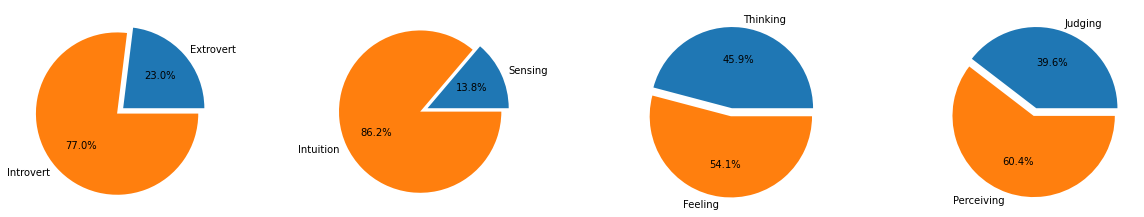

In [0]:
rcParams['figure.figsize'] = 20, 10
plt.subplots_adjust(wspace = 0.5)
ax1 = plt.subplot(1, 4, 1)
plt.pie([sum(myersBriggs16P_df["mundo_preferido"]), 
len(myersBriggs16P_df["mundo_preferido"]) - sum(myersBriggs16P_df["mundo_preferido"])], 
labels = labels[0:2],
explode = (0, 0.1),
autopct='%1.1f%%')

rcParams['figure.figsize'] = 20, 10
plt.subplots_adjust(wspace = 0.5)
ax1 = plt.subplot(1, 4, 2)
plt.pie([sum(myersBriggs16P_df["informacion"]), 
len(myersBriggs16P_df["informacion"]) - sum(myersBriggs16P_df["informacion"])], 
labels = labels[2:4],
explode = (0, 0.1),
autopct='%1.1f%%')

rcParams['figure.figsize'] = 20, 10
plt.subplots_adjust(wspace = 0.5)
ax1 = plt.subplot(1, 4, 3)
plt.pie([sum(myersBriggs16P_df["decision"]), 
len(myersBriggs16P_df["decision"]) - sum(myersBriggs16P_df["decision"])], 
labels = labels[4:6],
explode = (0, 0.1),
autopct='%1.1f%%')

rcParams['figure.figsize'] = 20, 10
plt.subplots_adjust(wspace = 0.5)
ax1 = plt.subplot(1, 4, 4)
plt.pie([sum(myersBriggs16P_df["estructuracion"]), 
len(myersBriggs16P_df["estructuracion"]) - sum(myersBriggs16P_df["estructuracion"])], 
labels = labels[6:8],
explode = (0, 0.1),
autopct='%1.1f%%')

plt.show()

In [0]:
accuracies_test=[]
accuracies_train=[]
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
modelos = {
    "NB":MultinomialNB(),
    "XGB":XGBClassifier(),
    "Logreg": LogisticRegression(solver='lbfgs'),
    "NN": KNeighborsClassifier(),
    "LinearSVM": SVC(probability=True, kernel='linear'), #class_weight='balanced'
    "GBC": GradientBoostingClassifier(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "NB": GaussianNB(),
}  
modelos2 = {
    "NB":MultinomialNB(),
    "XGB":XGBClassifier(),
    "Logreg": LogisticRegression(solver='lbfgs'),

}       
def clasificadorRasgos(df,actitud,model):
    y_f = df[actitud].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(Xpersonalities_df, y_f, stratify=y_f)
    clasificador = model
    print(f'-->Training {clasificador} para {actitud}...')
    clasificador.fit(X_f_train, y_f_train)
    print(f'--> {clasificador} training finished')
    #print("%s:" % aptitud, sum(y_f)/len(y_f))
    print("Accuracy en TRAIN de la actitud %s" % actitud, accuracy_score(y_f_train, clasificador.predict(X_f_train)))
    print("AUC %s" % actitud, roc_auc_score(y_f_test, clasificador.predict_proba(X_f_test)[:,1]))
    print(f"Para el modelo {model} "+"la Accuracy en TEST de la actitud %s" % actitud, accuracy_score(y_f_test, clasificador.predict(X_f_test)))
    accuracies_train.append(accuracy_score(y_f_train, clasificador.predict(X_f_train)))
    accuracies_test.append(accuracy_score(y_f_test, clasificador.predict(X_f_test)))
      
    return clasificador

**ALGORITMOS DE CLASIFICACIÓN**

Una vez que nos hemos creado la función que entrenará a nustro algoritmo con los datos de TRAIN y luego hará las predicciones, lo que vamos a hacer es entrenar una serie de algoritmos diferentes para ver y comparár sus resultados

Vamos a clasificar los 4 tipos con los siguientes algoritmos:

    MultinomialNB()
    XGBClassifier()
    LogisticRegression()
    KNeighborsClassifier(),
    SVC(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),

***Extraversión (E) o Introversión (I)***, según uno prefiera enfocarse al mundo exterior o al interior.

***Sensing (S) o Intuition (N)***. Según la preferencia esté en enfocarse en la información simple que uno percibe o en interpretarla y añadirle significado.

***Thinking (T) o Feeling (F)***. Según, al tomar decisiones, la preferencia esté en atender a la consistencia lógica de lo percibido o centrarse en las personas y las circunstancias especiales.

***Judging (J) o Perceiving (P)***, según, al tratar con el mundo exterior, la preferencia esté en tener las cosas decididas (preferencia por las funciones de juicio) o estar abierto a nueva información y opciones (preferencia por las funciones de percepción).


Después de hacer una prueba con todos los algoritmos del diccionario modelos, he optadopor acortar a 3 algoritmos ya que tardaba demasiado tiempo y las métricas no cambiaban a mejor.

Usamos el diccionario modelos2

*MultinomialNB()
*XGBClassifier()
*LogisticRegression()

In [0]:
clasificadores=[]
for model in modelos2.values():
  for actitud in actitudes:
    clasificador=clasificadorRasgos(myersBriggs16P_df,actitud,model)
  clasificadores.append(clasificador)

-->Training MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) para mundo_preferido...
--> MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) training finished
Accuracy en TRAIN de la actitud mundo_preferido 0.7695972948047956
AUC mundo_preferido 0.717346914319952
Para el modelo MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) la Accuracy en TEST de la actitud mundo_preferido 0.7694790225910558
-->Training MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) para informacion...
--> MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) training finished
Accuracy en TRAIN de la actitud informacion 0.8619735628650477
AUC informacion 0.7086580938243343
Para el modelo MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) la Accuracy en TEST de la actitud informacion 0.8621484555094514
-->Training MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) para decision...
--> MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) training finishe

Ya tenemos nuestros 4 clasificadores funcionando y los resultados de las métricas de cda uno de ellos en los datos de TEST son

In [0]:
i=0
for actitud in actitudes:
  for model in modelos2:
    print(chr(27)+"[1;32m"+f'Para {actitud} tenemos un accuracy en TRAIN del {accuracies_train[i]*100}% con el modelo {model}')
    print(chr(27)+"[1;33m"+f'Para {actitud} tenemos un accuracy en TEST del {accuracies_test[i]*100}% con el modelo {model}')
    i+=1

Para mundo_preferido tenemos un accuracy en TRAIN del 76.95972948047955% con el modelo NB
Para mundo_preferido tenemos un accuracy en TEST del 76.94790225910559% con el modelo NB
Para mundo_preferido tenemos un accuracy en TRAIN del 86.19735628650477% con el modelo XGB
Para mundo_preferido tenemos un accuracy en TEST del 86.21484555094514% con el modelo XGB
Para mundo_preferido tenemos un accuracy en TRAIN del 74.22379342145712% con el modelo Logreg
Para mundo_preferido tenemos un accuracy en TEST del 72.98294144767173% con el modelo Logreg
Para informacion tenemos un accuracy en TRAIN del 61.43559790962188% con el modelo NB
Para informacion tenemos un accuracy en TEST del 61.08805901337022% con el modelo NB
Para informacion tenemos un accuracy en TRAIN del 80.80233630494928% con el modelo XGB
Para informacion tenemos un accuracy en TEST del 77.50115260488705% con el modelo XGB
Para informacion tenemos un accuracy en TRAIN del 86.9658776513987% con el modelo Logreg
Para informacion ten

Podemos ver los resultados de los clasificadores 

Parece ser que uno de los mejores clasificadores es XGB, apartir de ahora vamos a usar las métricas y predicciones de este algoritmo para predecir

In [0]:
resultsTemp = {'train' : [86.19735628650477,81.20196741469414,76.37565324316016,81.89363664309867], 
        'test'  : [86.21484555094514,77.3167358229599,65.79068695251267,76.0258183494698]}
results = pd.DataFrame.from_dict(resultsTemp, orient='index', columns=['Introvert - Extrovert', 'Intuition - Sensing', 'Thinking - Feeling', 'Judging - Percieiving'])
results

Introvert - Extrovert  Intuition - Sensing  Thinking - Feeling  \
train              86.197356            81.201967           76.375653   
test               86.214846            77.316736           65.790687   

       Judging - Percieiving  
train              81.893637  
test               76.025818

Podemos ver que para Mundo_preferido tiene una muy buena precisión y para decisión bastante mas baja, que luego a la hora de predecir Los tipos de personalidad con los nuevos tweet se podrá confirmar,

Lo podemos plottear

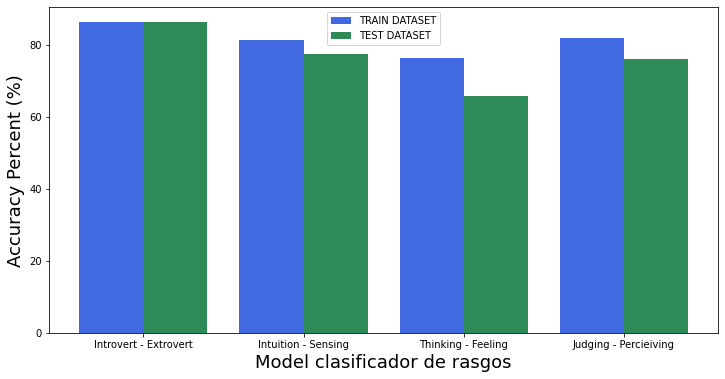

In [0]:
labels_personality = np.array(results.columns)

training = results.loc['train']
ind = np.arange(4)
width = 0.4
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, training, width, color='royalblue')

testing = results.loc['test']
rects2 = ax.bar(ind+width, testing, width, color='seagreen')

fig.set_size_inches(12, 6)
fig.savefig('Results.png', dpi=200)

ax.set_xlabel('Model clasificador de rasgos', size = 18)
ax.set_ylabel('Accuracy Percent (%)', size = 18)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels_personality)
ax.legend((rects1[0], rects2[0]), ('TRAIN DATASET', 'TEST DATASET'))
plt.show()

En la siguiente géfica podemos ver que es posible que para Mundo_favorito pueda existir algo de overfitting, pero viendo los resultados de los siguientes clasificadores me tiendo a pensar que no y seguimos adelante

De estos resultados podemos ver la importancia de cada feature que nos ha arrojado el algoritmo elegido.

Optamos por poner 20 features 

In [0]:
def showFeatureImportance():
  i=0
  for actitud in actitudes:
    y_f = myersBriggs16P_df[actitud].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(Xpersonalities_df, y_f, stratify=y_f)
    plot_importance(XGBClassifier().fit(X_f_train, y_f_train), max_num_features = 20)
    plt.title(f"Features asociadas a {actitudes[i]}")
    i+=1
    plt.show()

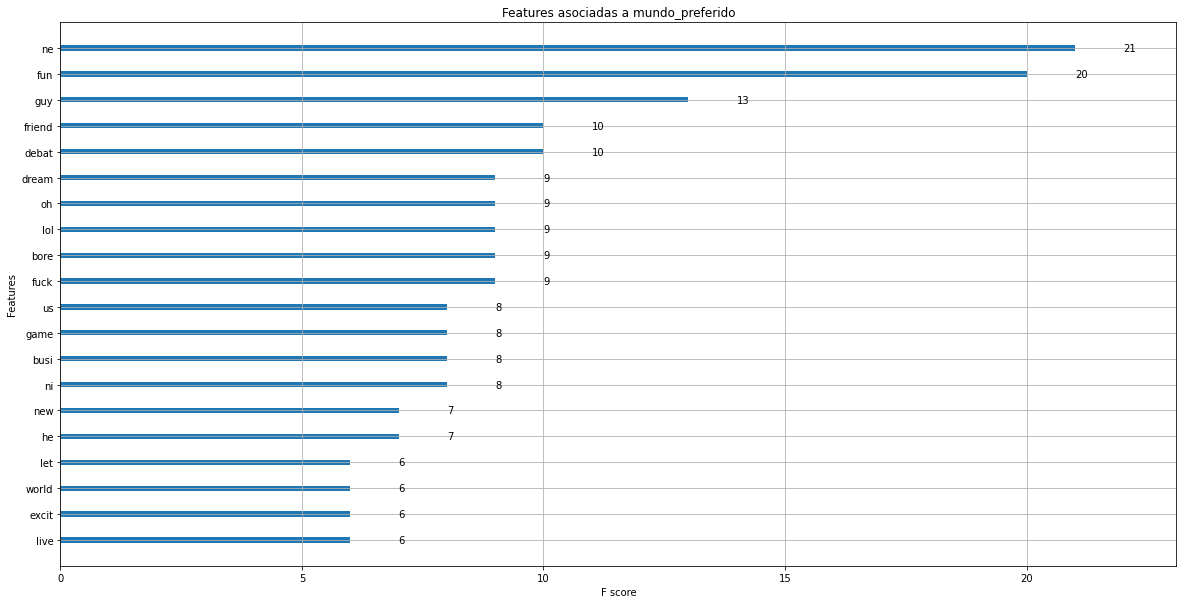

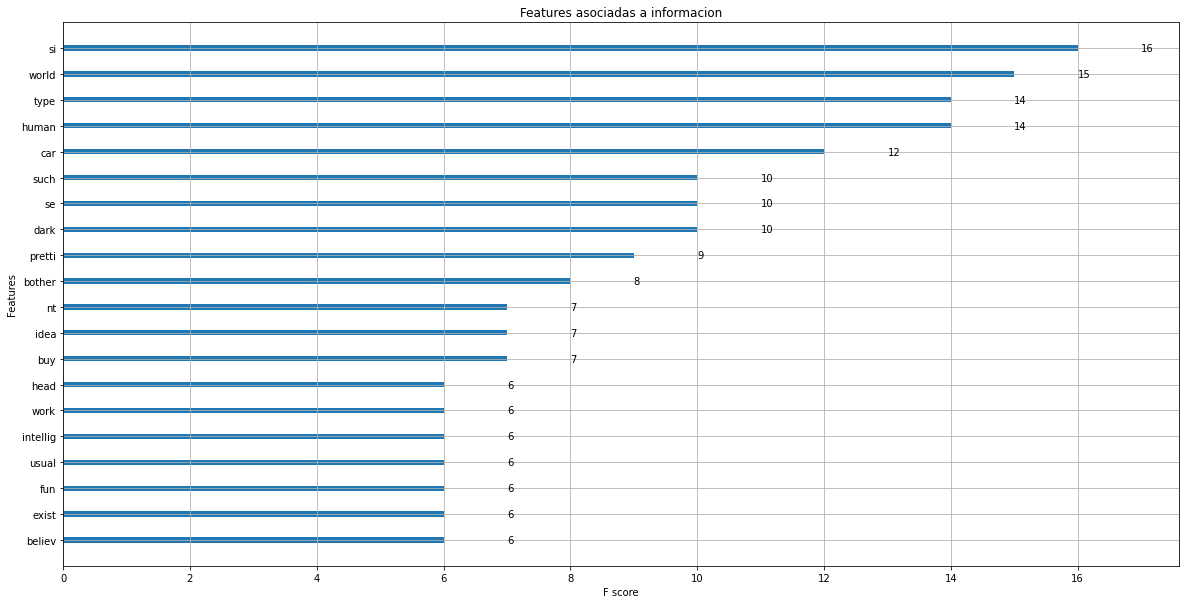

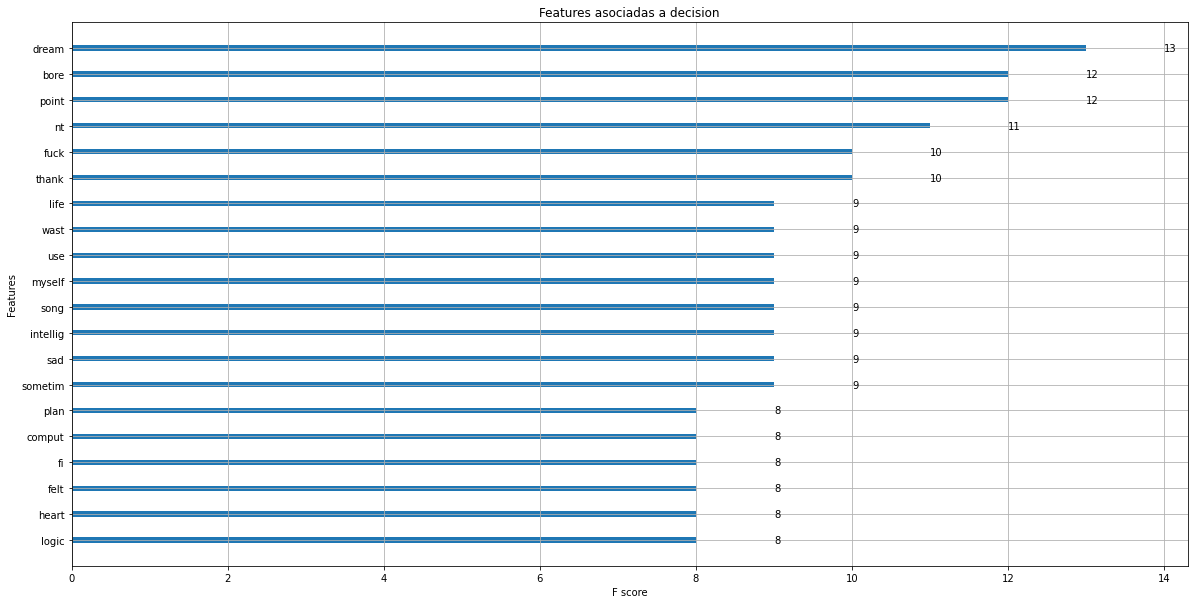

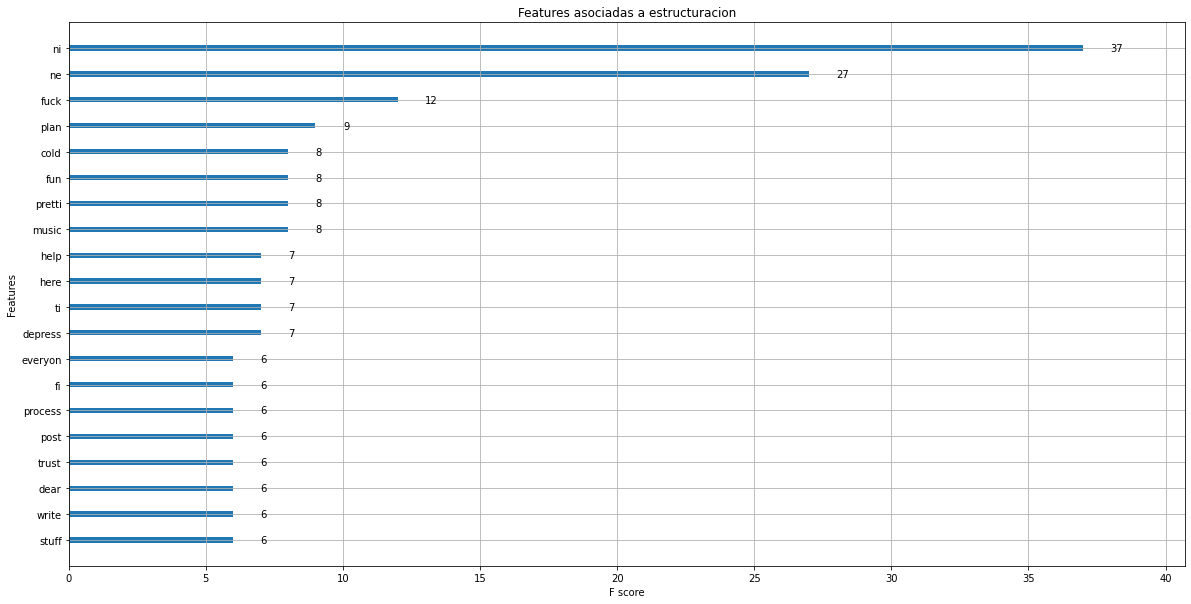

In [0]:
showFeatureImportance()

Ahora que ya sabemos cual es el mejor algoritmo para clasificación y prediccion de los 16 tipos de personaliad, vamos a probar nuestro algoritmo con datos nuevos que no ha visto.

In [0]:
def predictpersonalities(text):
  personality_result=[]
  personality_result_type=""
  text=tfizer.transform(vectorizer.transform([text])).toarray()
  test_point = pd.DataFrame.from_dict({w: text[:, i] for i, w in enumerate(palabras_total)})
  i=0
  for actitud in actitudes:
    y_f = myersBriggs16P_df[actitud].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(Xpersonalities_df, y_f, stratify=y_f)
    f_classifier = XGBClassifier()
    print(f'-->Training {XGBClassifier} para {actitud}...')
    f_classifier.fit(X_f_train, y_f_train, 
                     early_stopping_rounds = 10, 
                     eval_metric="logloss", 
                     eval_set=[(X_f_test, y_f_test)], verbose=False)
    print(f'Resultados para {actitud}', sub_classifier(actitud).predict_proba(test_point))
    if sub_classifier(actitud).predict(test_point)[0]==0:
        personality_result.append(labels[i])
    else:
        personality_result.append(labels[i+1])
    i+=2
  for rasgo in personality_result:
      personality_result_type=personality_result_type+rasgo[:1]
  print(f'El tipo de personalidad predicho es {personality_result_type}')
  explains=personalty_explain.values()
  for explain in personalty_explain:
    if explain==personality_result_type:
      print(f'El tipo de personalidad {explain} se caracteriza por: {personalty_explain[explain]}')
  #return personality_result_type

Podemos probar nuestros algoritmos con algún tweet que no conozca para ver que nos predice:


**Texto de El Cuervo de E.A.Poe**

In [0]:
theRaven="Be that word our sign of parting, bird or fiend! I shrieked, upstarting—Get thee back into the tempest and the Night’s Plutonian shore!Leave no black plume as a token of that lie thy soul hath spoken!Leave my loneliness unbroken!—quit the bust above my door!Take thy beak from out my heart, and take thy form from off my door!Quoth the Raven Nevermore.And the Raven, never flitting, still is sitting, still is sittingOn the pallid bust of Pallas just above my chamber door;And his eyes have all the seeming of a demon’s that is dreaming,And the lamp-light o’er him streaming throws his shadow on the floor;And my soul from out that shadow that lies floating on the floorShall be lifted—nevermore!".lower()
predictpersonalities(theRaven)

-->Training <class 'xgboost.sklearn.XGBClassifier'> para mundo_preferido...
Resultados para mundo_preferido [[0.8465396  0.15346041]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para informacion...
Resultados para informacion [[0.86175346 0.1382465 ]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para decision...
Resultados para decision [[0.5423993 0.4576007]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para estructuracion...
Resultados para estructuracion [[0.5714084  0.42859158]]
El tipo de personalidad predicho es ESFJ
El tipo de personalidad ESFJ se caracteriza por: Afectuoso, concienzudo y cooperativo. Quiere armonía en su entorno, trabaje con determinación para establecerla. Le gusta trabajar con otros para completar tareas con precisión y a tiempo. Leal, sigue hasta en asuntos pequeños. Observe lo que otros necesitan en su vida cotidiana e intente proporcionarlo. Quiere ser apreciado por quienes son y por lo que contribuyen.


**Texto de Hojas de hierba de Walt Whitman**

In [0]:
waltWhitman="I wish I could translate the hints about the dead young men and women,And the hints about old men and mothers, and the offspring taken soon out of their laps.What do you think has become of the young and old men?And what do you think has become of the women and children?They are alive and well somewhere,The smallest sprout shows there is really no death,And if ever there was it led forward life, and does not wait at the end to arrest it,And ceas'd the moment life appear'd.All goes onward and outward, nothing collapses,And to die is different from what any one supposed, and luckier.".lower()
predictpersonalities(waltWhitman)

-->Training <class 'xgboost.sklearn.XGBClassifier'> para mundo_preferido...
Resultados para mundo_preferido [[0.8673544  0.13264562]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para informacion...
Resultados para informacion [[0.803347   0.19665298]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para decision...
Resultados para decision [[0.6288165  0.37118354]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para estructuracion...
Resultados para estructuracion [[0.56065106 0.43934894]]
El tipo de personalidad predicho es ESTJ
El tipo de personalidad ESTJ se caracteriza por: Práctico, realista, práctico. Decisivo, moverse rápidamente para implementar decisiones. Organice proyectos y personas para hacer las cosas, concéntrese en obtener resultados de la manera más eficiente posible. Cuida los detalles de rutina. Tenga un conjunto claro de estándares lógicos, sígalos sistemáticamente y desee que otros también lo hagan. Enérgico en la implementación de sus planes.


**Texto de A smile to remember de Charles Bukowski**

In [0]:
charlesBokowski="we had the goldfish and they went around and around in the bowl on the table near the purple drapes across our front picture window and my mother, poor fish, always smiling, wanting to appear happy, she always told me, 'be happy, Henry,' and she was right: it's better to be happy if you can be but my father beat her two or three times a week while raging through his 6 foot two frame because he couldn't defeat what was attacking him. my mother, poor fish, poor goldfish, poor nothing fish, wanting to be happy, being beaten two or three times a week and telling me to be happy: Henry, smile! why don't you smile?".lower()
label=predictpersonalities(charlesBokowski)

-->Training <class 'xgboost.sklearn.XGBClassifier'> para mundo_preferido...
Resultados para mundo_preferido [[0.8284615  0.17153846]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para informacion...
Resultados para informacion [[0.803254   0.19674599]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para decision...
Resultados para decision [[0.49523717 0.5047628 ]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para estructuracion...
Resultados para estructuracion [[0.53555906 0.46444094]]
El tipo de personalidad predicho es ESTP
El tipo de personalidad ESTP se caracteriza por: Flexibles y tolerantes, adoptan un enfoque pragmático centrado en resultados inmediatos. Las teorías y explicaciones conceptuales los aburren: quieren actuar enérgicamente para resolver el problema. Concéntrese en el aquí y ahora, espontáneo, disfrute cada momento que puedan estar activos con los demás. Disfruta de las comodidades materiales y el estilo. Aprende mejor haciendo.


**Texto de explicación tipo de personalidad ESFJ**

In [0]:
ESFJ_explain="Warmhearted, conscientious, and cooperative. Want harmony in their environment, work with determination to establish it. Like to work with others to complete tasks accurately and on time. Loyal, follow through even in small matters. Notice what others need in their day-by-day lives and try to provide it. Want to be appreciated for who they are and for what they contribute.".lower()
label=predictpersonalities(ESFJ_explain)

-->Training <class 'xgboost.sklearn.XGBClassifier'> para mundo_preferido...
Resultados para mundo_preferido [[0.82811713 0.1718829 ]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para informacion...
Resultados para informacion [[0.7407899 0.2592101]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para decision...
Resultados para decision [[0.38397926 0.61602074]]
-->Training <class 'xgboost.sklearn.XGBClassifier'> para estructuracion...
Resultados para estructuracion [[0.51353276 0.48646724]]
El tipo de personalidad predicho es ESFP
El tipo de personalidad ESFP se caracteriza por: Extrovertida, amigable y receptiva. Amantes exuberantes de la vida, las personas y las comodidades materiales. Disfruta trabajando con otros para que las cosas sucedan. Aportan sentido común y un enfoque realista a su trabajo, y hacen que el trabajo sea divertido. Flexible y espontáneo, se adapta fácilmente a nuevas personas y entornos. Aprende mejor probando una nueva habilidad con otras personas